# Performance analysis of the different experiments in the manuscript

This notebook provides the analysis used to generate the different performance figures in the manuscript

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import r_regression
import scikit_posthocs as sp
import seaborn as sns

## Defining setup
* We start by identifying the directories for the results of the experiments run by us, as well as the comparisons to other transformer models and baselines (`L1` and `L2`). 
* We also specify the split method of the evaluation. set `datasail = True` if you want the datasail split results, and `datasail = False` to retrieve the random split results (`L4`)
    * For each split type, we performed 5-fold cross validation
* The results files provide different evaluation metrics, namely, mean absolute error (MAE), root mean squared error (RMSE), and coefficient of determination ( $R^2$ ). Change the metric to any of the commented values at `L10` to get the results for the metric of desire. 
    * The MAE and RMSE results together will help identify the error ranges of each model for each dataset and whether the models have many outlier predictions. However, actual identification of whether a model performs well or bad will depend on the values range of each endpoint. Therefore, comparisons across endpoints will not be feasible. 
        * Additionally, each endpoint has its own restrictions to which error ranges can be tolerated. In this manuscript, we do not delv into applicability domain and acceptable error ranges. Consequently, while the MAE and RMSE can help us compare models together on the same dataset, they don't help us identify how good a model really is with respect to each dataset's real-world application. 
    * The $R^2$ value compares the model's performance to the performance of a basic model that always predicts the mean value ( $\bar{X}$ ). While the metric is still limited in providing a real-world picture, it helps identify how much better each model is, compared to the most basic model. Therefore, we opted for this metric as our main reporting metric. 
* We used different algorithms on the embedding produced by our models, the compared transformer models, and the physicochemical properties and morgan fingerprints by RDKit. These models are `linear regression`, `random forest`, and `support vector machines (SVM)`. Change the value at `L18` to pick one of the algorithms to fetch the corresponding values. 
    * The linear regression model was found to perform terribly using the $R^2$ metric (i.e., many values are < 0, which means that the model is worse than simply predicting the mean value). 
        * We suspect the reason to be that the embeddings, PhysChem properties, and morgan fingerprints exhibit non-linear relationships. Therefore, linear regression is an inappropriate model for such feature space. 
    * The random forest and svm models learn non-linear relationships, therefore, both would provide better performance than linear regression. We **arbitrary** picked the random forest model as the main reporting algorithm. 
* Finally, we set the output directory and create it (`L28`, `L29`). This will be the directory where all the figures will be saved to. 
    * The output folder already contains the figures for the random forest algorithm and all three evaluation metrics. 

### This notebook shows the example for the DataSAIL splitting and the $R^2$ metric


In [2]:
experiment_dir = 'results_with_clustered_pretraining_cleaned_adme_microsom'
comparison_dir = 'comparison_with_clustered_pretraining_cleaned_adme_microsom'

datasail = True
if datasail:
    split_file = 'datasail'
else:
    split_file = 'random'
    
metric = 'R2' # 'MAE', 'RMSE', 'R2'

# making sure that R2 will be written with a superscript in the plots
metric_styling = {'R2': '$R^2$', 'MAE': 'MAE', 'RMSE': 'RMSE'}

# adding an arrow to indicate which direction of the values correspond to a better performance
arrow_direction = {'R2': '↑', 'MAE': '↓', 'RMSE': '↓'}

algorithm = 'random-forest' # 'linear' 'svm' 'random-forest'

# Rename the domain-adaptation objectives (just a beatification measure!) 
da_objectives = ["No DA", "MTR", "CL", "MLM"]
old_da_names = ["none", "mtr", "cbert", "mlm"]
renamed_da = dict(zip(old_da_names, da_objectives))

# Set the colors to be used for each domain adaptation objective
da_colors = dict(zip(da_objectives, ["tab:blue", "tab:green", "tab:orange", "tab:purple"]))

out_dir = f'analysis_figures/{split_file}_splitting_analysis/{metric}/{algorithm}'
os.makedirs(out_dir, exist_ok=True)

## Loading our experiment results
* Here, we load the raw predictions of our models as well as the evaluated predictions where each fold has a corresponding MAE, RMSE, and $R^2$. We filter by metric and algorithm as defined above.
* We have 4 variants of our pre-trained models:
    1. 0%: a randomly initialized model with no pre-training
    2. 30%: a model pre-trained with 30% of the GuacaMol dataset (i.e., ~400K molecules)
    3. 60%: a model pre-trained with 60% of the GuacaMol dataset (i.e., ~800K molecules)
    4. 100%: a model pre-trained with the full GuacaMol dataset (i.e., ~1.3M molecules)
* Our transformer models have been pre-trained using one of two pre-training objectives. We split our results into these two objective as we compare them to each other. These two objectives are: 
    1. Masked Language Modelling (MLM). This objective strictly learns structural information as provided by the SMILES string
    2. Multi-Task Regression (MTR). This objective teaches the model to predict a vector of ~210 physicochemical properties. Therefore, it's a chemically aware objective. 



In [3]:
# Loading the raw results. Here, we have the prediction for each data point in each fold of the 5-folds. 
experiments_raw_values = f'{experiment_dir}/{split_file}_results_all.csv'
experiments_raw_df = pd.read_csv(experiments_raw_values, index_col=0)

# Filtering the predictions by the specified algorithm
experiments_raw_df = experiments_raw_df[experiments_raw_df["algorithm"] == algorithm]

# Loading the evaluated file. Here, we have the different metrics for each fold of the 5-folds 
experiments_metrics = f'{experiment_dir}/{split_file}_metrics_df.csv'
experiments_metrics_df = pd.read_csv(experiments_metrics, index_col=0)

# Filtering the predictions by the specified metric and algorithm
experiments_metrics_df = experiments_metrics_df[(experiments_metrics_df['metric'] == metric) & (experiments_metrics_df["algorithm"] == algorithm)]

# We hard-code the datasets list to enforce the provided sorting. This makes the HLM and RLM datasets on top of each other and the hPPB and rPPB datasets next to each other.
datasets = ['Solubility', 'Permeability', 'HLM', 'hPPB', 'rPPB', 'RLM']

# Retrieve the different dataset sizes to use for looping when needed
ds_sizes = sorted(experiments_metrics_df['train_size'].unique().tolist())

# Split the analysis by pre-training objective for both raw and evaluated predictions
raw_mlm_pretrained_models = experiments_raw_df[experiments_raw_df['objective'] == 'mlm']
raw_mtr_pretrained_models = experiments_raw_df[experiments_raw_df['objective'] == 'mtr']
raw_df_by_objective = {'mlm': raw_mlm_pretrained_models, 'mtr': raw_mtr_pretrained_models}

mlm_pretrained_models = experiments_metrics_df[experiments_metrics_df['objective'] == 'mlm']
mtr_pretrained_models = experiments_metrics_df[experiments_metrics_df['objective'] == 'mtr']
df_by_objective = {'mlm': mlm_pretrained_models, 'mtr': mtr_pretrained_models}

## Loading comparison results
Here, we load the same files as loaded above, but for the compared models this time. The models are:
1. MolBERT
2. MolFormer
3. RF + PhysChem properties
4. RF + ECFP4 (Morgan fingerprints)

### calculating standard errors
We mostly report the evaluated predictions as a boxplot with the 5 values for each fold shown on the boxplot, but when the models are too many, we visualize it as an error bar plot with the mean metric prediction and the standard error of means (SEM, aka, SE).
* The below code aggregates the evaluated predictions and calculate the SE for each setup. 

In [4]:
def agg_mean_and_sem(df, comparison=False):
    group_by = ["dataset", "train_size", "da"]
    if comparison:
        group_by = ["dataset", "model"]
    aggregated_df = df.groupby(group_by)["value"].agg(["mean", "sem"]).reset_index()
    return aggregated_df

mlm_pretrained_models_agg = agg_mean_and_sem(df=mlm_pretrained_models)
mtr_pretrained_models_agg = agg_mean_and_sem(df=mtr_pretrained_models)
agg_by_objective = {'mlm': mlm_pretrained_models_agg, 'mtr': mtr_pretrained_models_agg}

## Setting plotting variables
* Figures are saved as PDFs for high quality
* Specified font size is used to control all the fonts in a plot
* The `plot_sns_heatmap` function is used to plot the significance matrix as a heatmap. 

In [5]:
figure_extension = 'pdf'
sns.set_style('white')
fontsize = 18

ncols = 3
fig_width = 15
fig_height_ratio = 4

def make_figure(n_datasets, n_cols, width=10, height_ratio=4):
    # Create a subplot grid
    n_rows = int(np.ceil(n_datasets / n_cols))  # Define number of rows (customized based on the specified number of columns)
    figure, subplots = plt.subplots(n_rows, n_cols, figsize=(width, height_ratio * n_rows))  # Create a grid of subplots
    subplots = subplots.flatten()  # Flatten the axes for easy iteration
    return figure, subplots

def format_ticks(value, tick_number=2):
    return f"{value:.2f}"

def plot_sns_heatmap(significance_mat, fig_ax, apply_mask=False):
    # Define the thresholds and corresponding colors
    thresholds = [0, 0.001, 0.01, 0.05, 1]  # Boundaries for four intervals
    colors = ['#005a32', '#238b45', '#a1d99b', '#fbd7d4']  # Colors for each category

    # Create the colormap and normalize with boundaries
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(thresholds, cmap.N)

    if apply_mask:
        mask = np.zeros_like(significance_mat, dtype=bool)
        # Fill the diagonal with True values
        np.fill_diagonal(mask, True)
    else:
        mask = None

    # Plot the heatmap with continuous data values
    heatmap = sns.heatmap(significance_mat, ax=fig_ax, cmap=cmap, norm=norm, annot=True, fmt=".3f",
                          cbar_kws={'ticks': [0.0005, 0.005, 0.03, 0.5]}, linewidths=0.6, linecolor='black',
                          clip_on=False, mask=mask)

    # Customize the color bar to reflect categories
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([0.0005, 0.005, 0.03, 0.5])  # Set tick positions within each range
    colorbar.set_ticklabels(['p < 0.001', 'p < 0.01', 'p < 0.05', 'NS'])  # Custom tick labels
    colorbar.ax.tick_params(labelsize=14)


# Performance analysis

In the manuscript, we had four research questions:
1. How does increasing pre-training dataset size affect performance?
2. How does domain adaptation with different objectives affect downstream performance?
3. What is the most efficient training approach without compromising performance?
4. How does domain adaptation compare to currently existing transformer and baseline models?

In the following, we will be showing the analysis used to answer these questions. 

## Pre-training dataset size
The below code plots the performance of the different models with different pre-training dataset sizes a boxplot. Three figures are generated:
1. Performance for the models pre-trained with the MLM objective
2. Performance for the models pre-trained with MTR objective
3. Comparing the MLM vs MTR performance

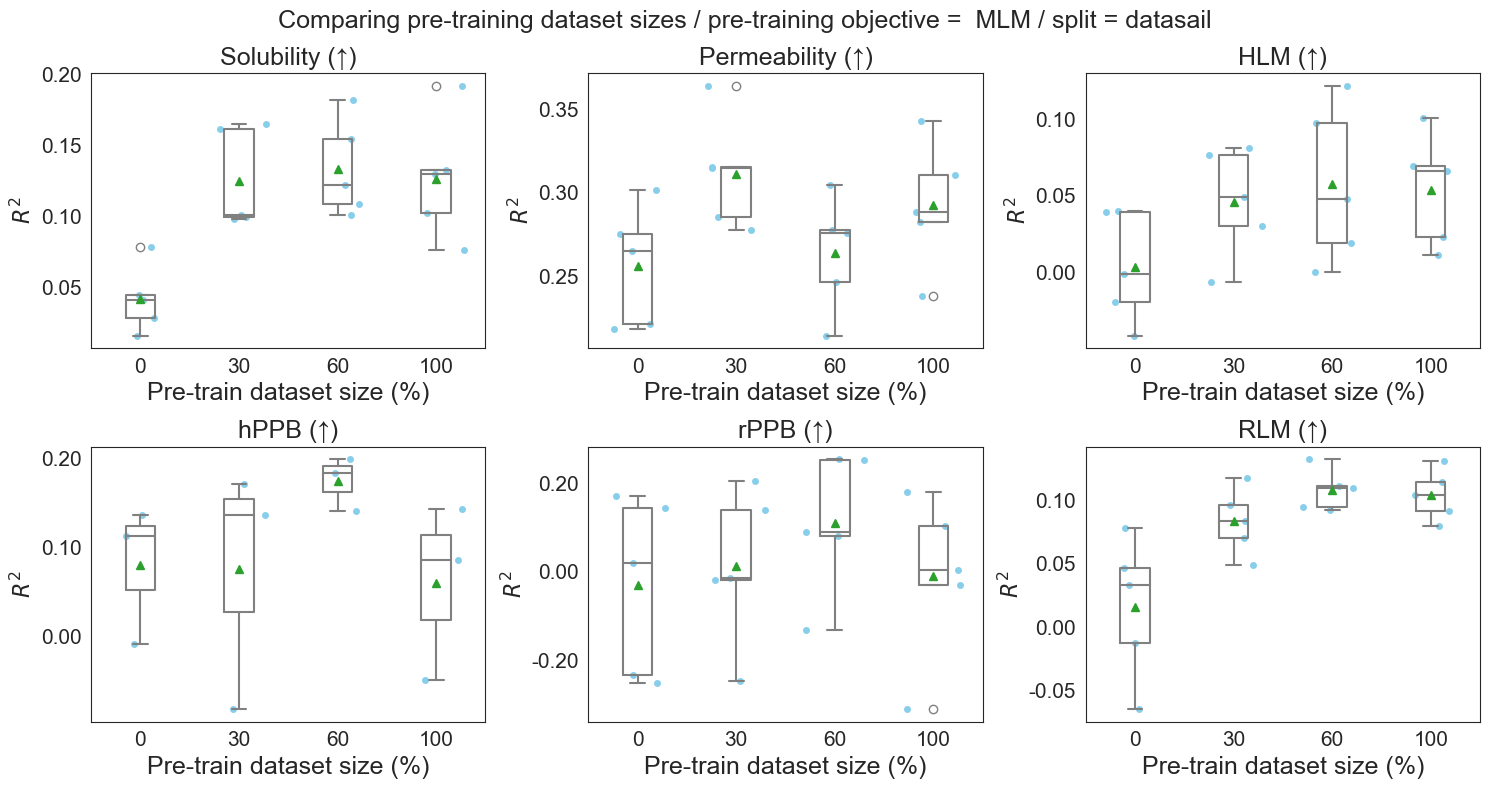

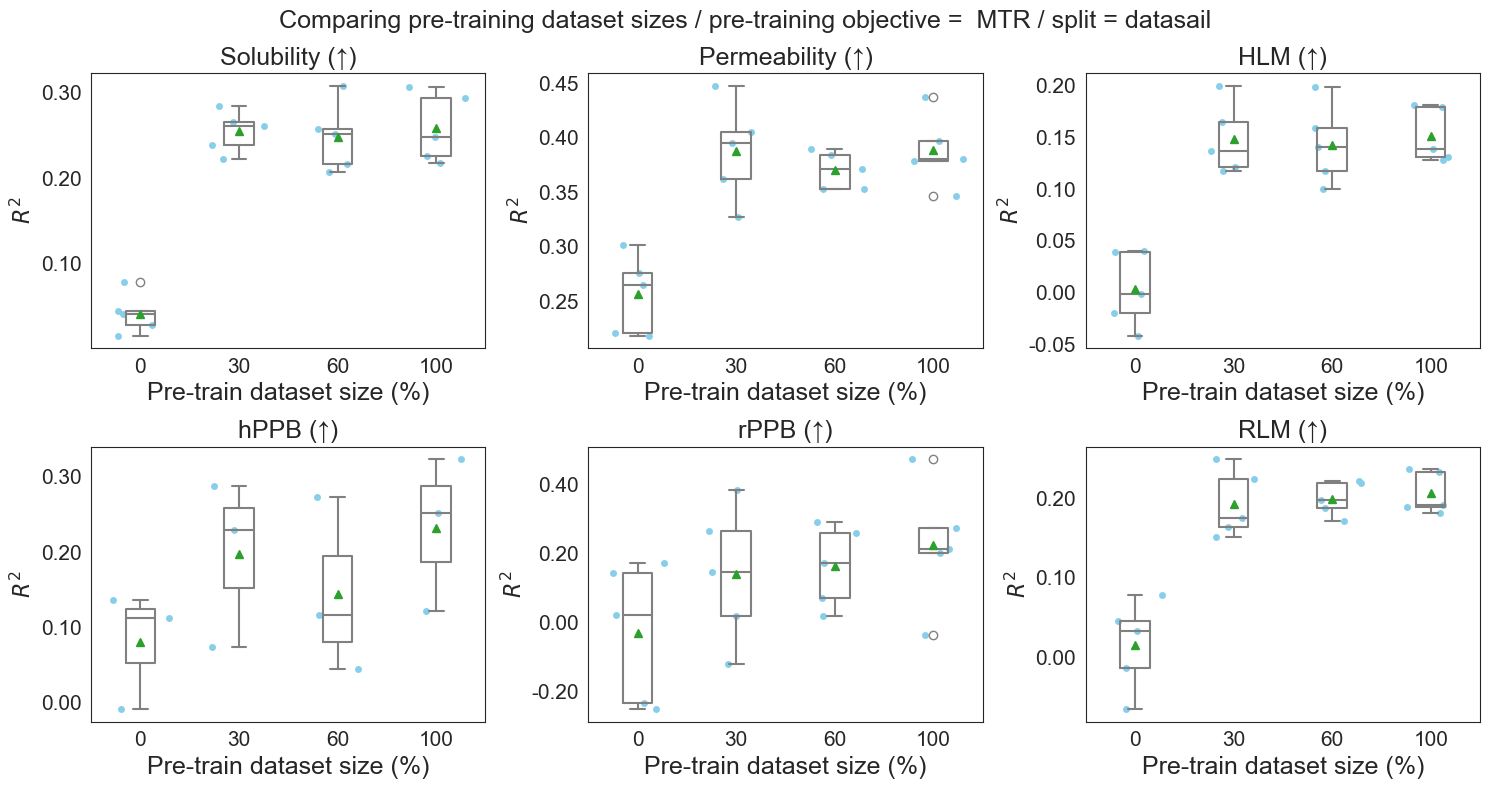

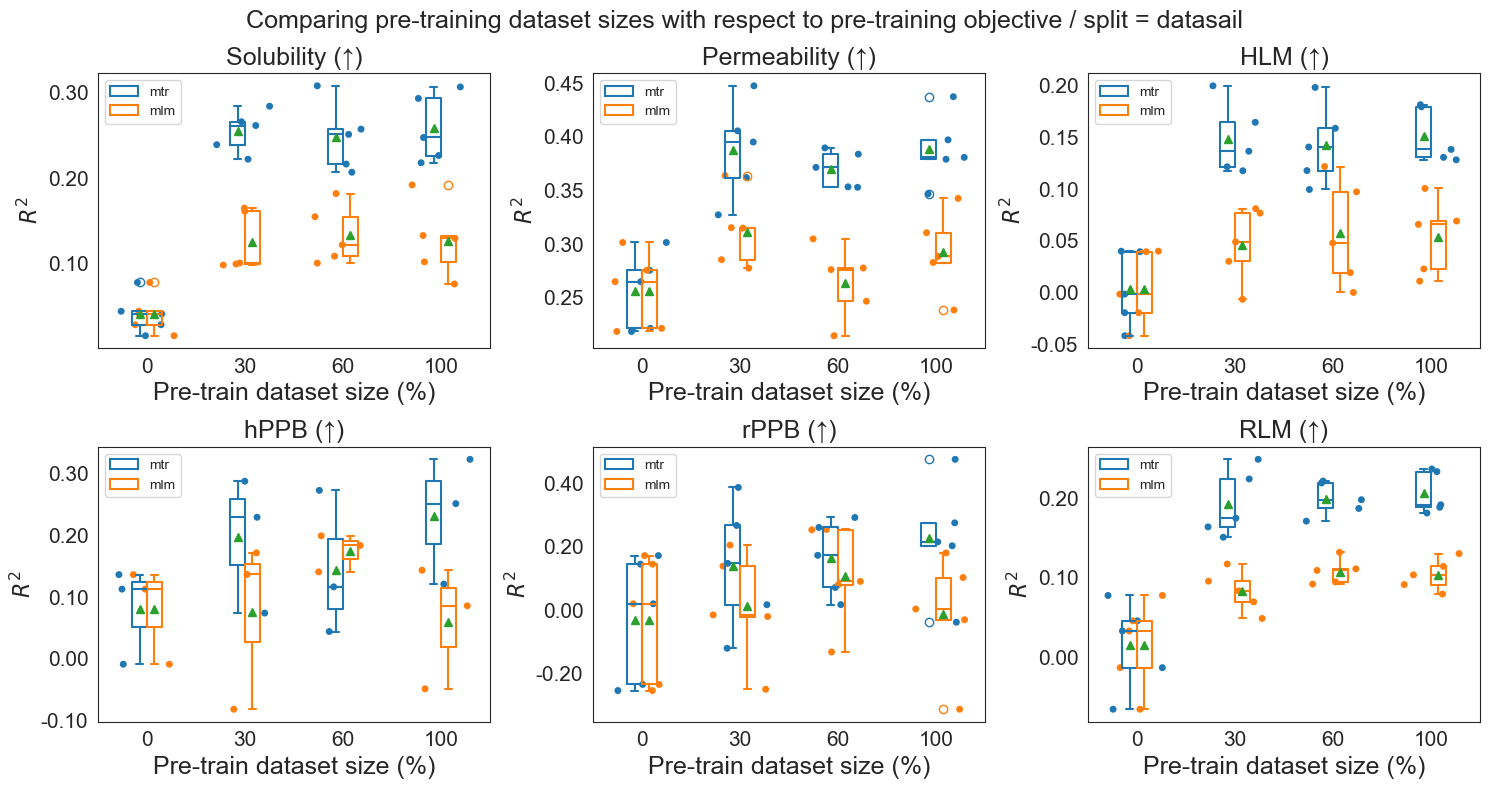

In [6]:
plt.close()
fig_name = 'scaling_boxplot'

for pretrain_objective in ['mlm', 'mtr', 'mlm_vs_mtr']:  
    updated_fig_name =  f'{pretrain_objective}_{fig_name}'
    
    # Create a subplot grid with one subplot for each dataset
    fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
    for idx, ds in enumerate(datasets):
        ax = axes[idx]
        ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
        ax.set_xlabel('Pre-train dataset size (%)', fontsize=fontsize)
        ax.set_ylabel(f'{metric_styling[metric]}', fontsize=fontsize-2)
        ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        
        if pretrain_objective != 'mlm_vs_mtr':
            objective_df = df_by_objective[pretrain_objective]
            ds_df = objective_df[(objective_df['dataset'] == ds) & (objective_df['da'] == 'No DA')]
            sns.boxplot(data=ds_df, x='train_size', y='value', color='gray', width=0.3, showmeans=True, fill=False, ax=ax)
                        
            # Overlay individual data points
            sns.stripplot(data=ds_df, x='train_size', y='value', color='skyblue', jitter=0.3, size=5, zorder=1, ax=ax)
        else:
            ds_df = experiments_metrics_df[(experiments_metrics_df['dataset'] == ds) & (experiments_metrics_df['da'] == 'No DA')]
            sns.boxplot(data=ds_df, x='train_size', y='value', width=0.3, showmeans=True, fill=False, ax=ax, hue='objective')
                    
            # Overlay individual data points
            sns.stripplot(data=ds_df, x='train_size', y='value', jitter=0.3, size=5, zorder=1, ax=ax, hue='objective')
                
            handles, labels = ax.get_legend_handles_labels()
        
            ax.legend(handles[0:2], labels[0:2])
    
        
    if pretrain_objective != 'mlm_vs_mtr':
        suptitle = f'Comparing pre-training dataset sizes / pre-training objective =  {pretrain_objective.upper()}'
    else:
        suptitle = f'Comparing pre-training dataset sizes with respect to pre-training objective'

    plt.suptitle(f'{suptitle} / split = {split_file}', fontsize=fontsize)
    # Adjust layout and save figure
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'{updated_fig_name}.{figure_extension}'))
    plt.show()

### Significance analysis
We perform the non-parameteric `Mann-Whitney U` test (aka, Wilcoxon rank) to obtain a P-value for the pairwise comparison between each model. We correct the multiple testing using the `Holms` correction method. 
* We followed the recommendations from Pat walters blog post [here](https://practicalcheminformatics.blogspot.com/2019/03/multiple-comparisons-non-parametric.html)

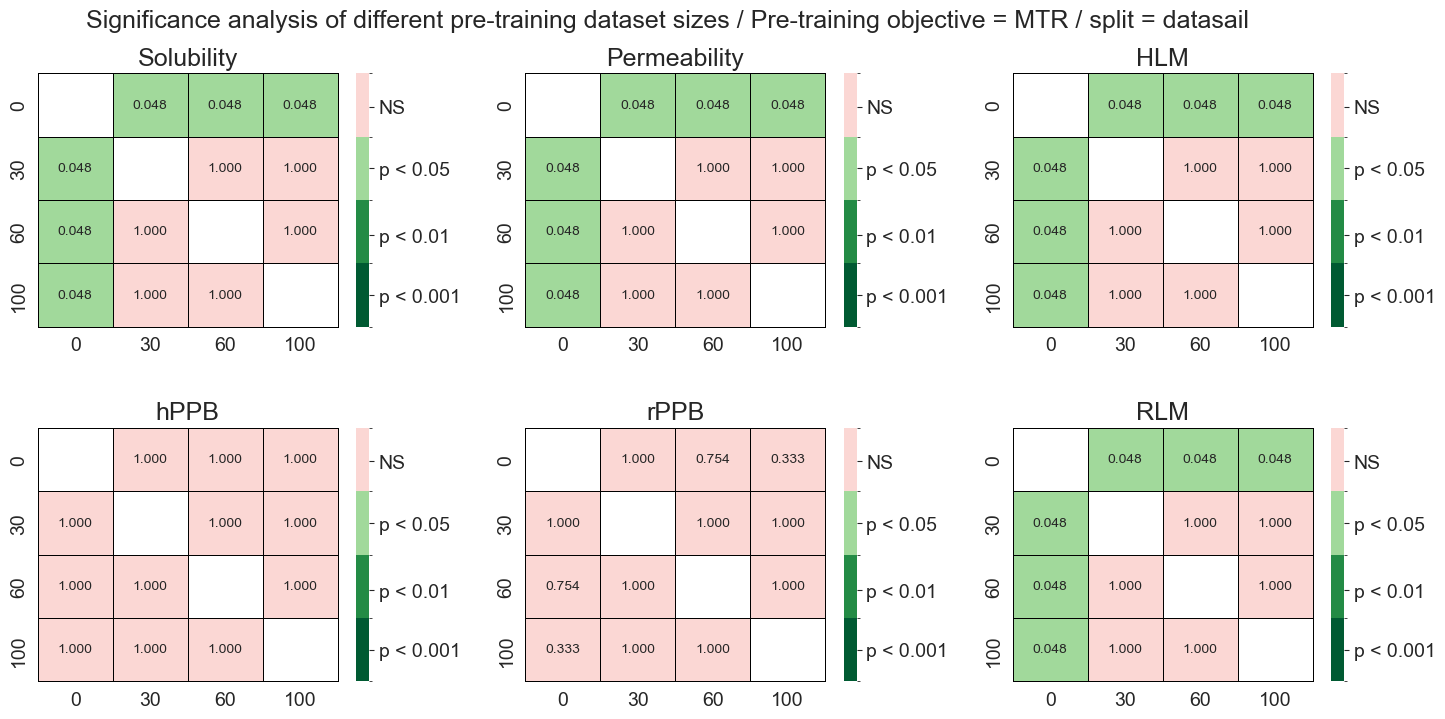

In [7]:
plt.close()
fig_name = 'scaling_significance'

for pretrain_objective in ['mlm', 'mtr']:  
    updated_fig_name =  f'{pretrain_objective}_{fig_name}'
    # Create a subplot grid with one subplot for each dataset
    fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)  
    objective_df = df_by_objective[pretrain_objective]
    for idx, ds in enumerate(datasets):
        ax = axes[idx]
        ax.set_title(f'{ds}', fontsize=fontsize)
        ds_df = objective_df[(objective_df['dataset'] == ds) & (objective_df['da'] == 'No DA')]
        
        # Perform pairwise comparisons across 'train_size' for the 'No DA' model
        significance_matrix = sp.posthoc_mannwhitney(ds_df,
                                                     val_col="value", 
                                                     group_col="train_size", 
                                                     p_adjust='holm')
        
        plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
        ax.tick_params(axis='both', labelsize=fontsize-4)
        
    wspace=0.3
    hspace=0.4
    top = 0.9 
    bottom = 0.14
    right = 0.98
    left = 0.08
    plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace) 
    
    plt.suptitle(f'Significance analysis of different pre-training dataset sizes / Pre-training objective = {pretrain_objective.upper()} / split = {split_file}', fontsize=fontsize)
    
    # Show the complete figure with all subplots
    plt.savefig(os.path.join(out_dir, f'{updated_fig_name}.{figure_extension}'))
    plt.show()

# Bonus - pairwise comparison is different from multiple comparisons

* The results from increasing pre-training dataset size does not show significance between the 0% setup and the 30% setup for most of the endpoints when MLM is the pre-training objective. However, multiple testing requires a stricter P-value which leads to the loss of some signals. 
* When considering these two models solely without comparing the 4 different setups together, we end up seeing that pre-training with 30% of the GuacaMol dataset is generally significantly better than no pre-training at all (the 0% setup).

NB: change the train sizes in `L3` and `L4` to compare any two models you like. We already found that the pairwise significance changed only for the 0% vs 30% setups, but remained for the rest of the setups.

In [22]:
pretrain_objective = 'mlm'
pretrain_objective_df = df_by_objective[pretrain_objective]
train_siz_1 = 0
train_size_2 = 30
mlm_0 = pretrain_objective_df[(pretrain_objective_df['da'] == 'No DA') & (pretrain_objective_df['train_size'] == train_siz_1)]
mlm_30 = pretrain_objective_df[(pretrain_objective_df['da'] == 'No DA') & (pretrain_objective_df['train_size'] == train_size_2)]
standard_models = pd.concat([mlm_0, mlm_30])
standard_models.loc[:, 'model'] = pretrain_objective.upper() + '_' + standard_models['train_size'].astype(str) + '%'

#standard_models = literature_plus_ours[literature_plus_ours['model'].isin(['MLM_30%_MTR', 'RF + PhysChem'])]

fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
    ax.set_ylabel(f'{metric_styling[metric]}', fontsize=fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    
    ds_df = standard_models[standard_models['dataset'] == ds].sort_values(by='model')
    
    sns.boxplot(data=ds_df, x='model', y='value', color='gray', width=0.3, showmeans=True, fill=False, ax=ax)
    
    # Overlay individual data points
    sns.stripplot(data=ds_df, x='model', y='value', color='skyblue', jitter=0.3, size=5, zorder=1, ax=ax)
        
    ax.set_xlabel('', fontsize=fontsize)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.subplots_adjust(hspace=0.6, wspace=0.3)

plt.suptitle(f'Comparison of the performance of the {train_siz_1}% and {train_size_2}% pre-training dataset size setups / split = {split_file}', fontsize=fontsize)
plt.savefig(os.path.join(out_dir, f'{pretrain_objective}_{train_siz_1}_vs_{train_size_2}_boxplot.{figure_extension}'))
plt.show()

plt.close()
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(dataset, fontsize=fontsize+2)
        
    df_dataset = standard_models[standard_models['dataset'] == dataset]
        
    # Perform pairwise comparisons across 'train_size' for the 'None' DA model
    significance_matrix = sp.posthoc_mannwhitney(df_dataset, 
                                                 val_col="value", 
                                                 group_col='model', 
                                                 p_adjust='holm')
        
    plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
    ax.tick_params(axis='both', labelsize=fontsize-2)
        
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
    current_labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(current_labels, rotation=15, ha='right')
        
wspace = 0.6 
hspace = 0.35 
top = 0.9 
bottom = 0.1
right = 0.95
left = 0.08
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
plt.suptitle(f'Significance analysis of the the performance of the {train_siz_1}% and {train_size_2}% pre-training dataset size setups / split = {split_file}', fontsize=fontsize+2)
plt.savefig(os.path.join(out_dir, f'{pretrain_objective}_{train_siz_1}_vs_{train_size_2}_significance.{figure_extension}'))
plt.show()

## Domain adaptation
We show the error bars for the models with no domain adaptation (`No DA`, in blue) to the different domain adaptation objectives per pre-training dataset size. The code shows one figure for the models pre-trained with the MLM objective
* The DA experiments were not fully performed for the models pre-trained with the MTR objectives as it was not part of our research questions. 

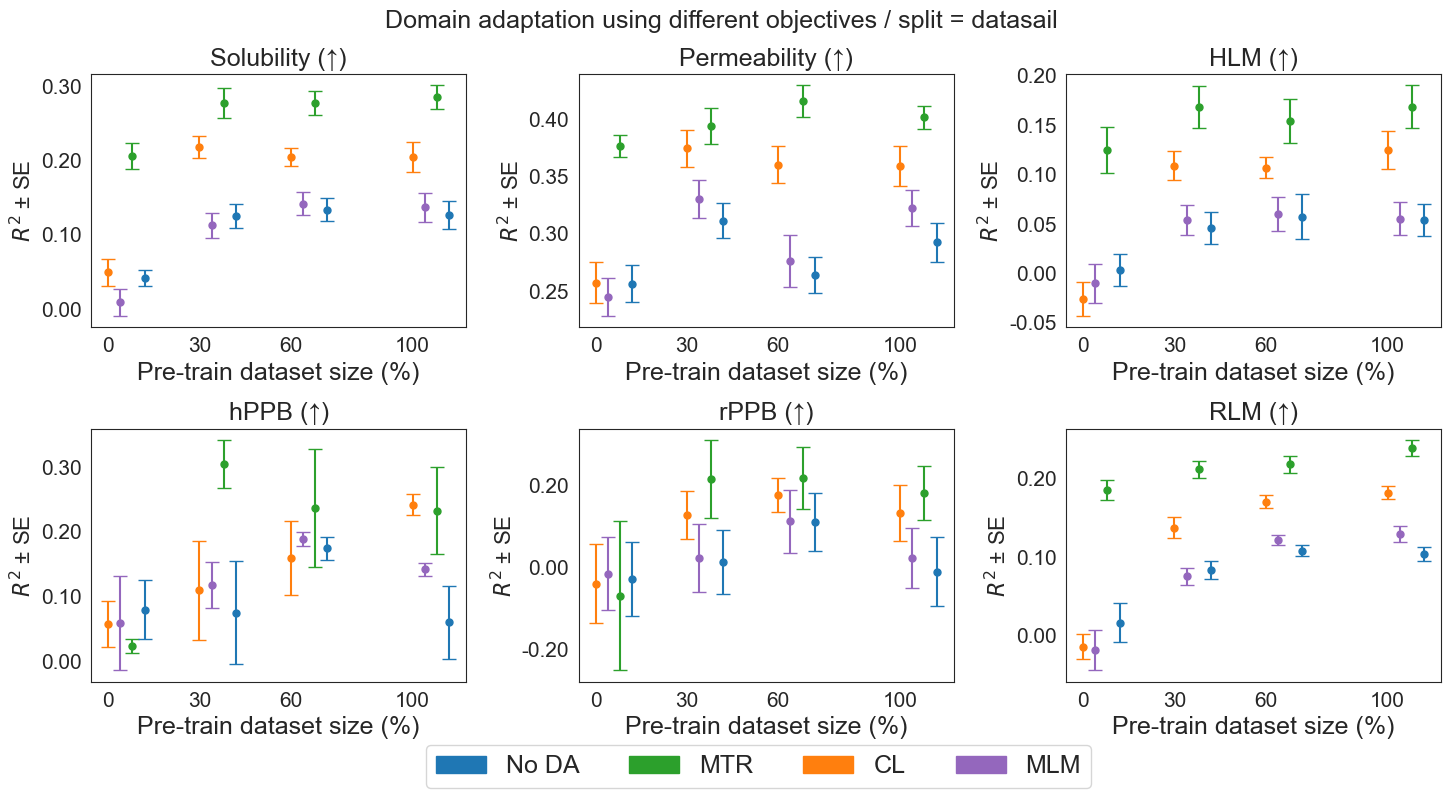

In [9]:
plt.close()
pretrain_objective = 'mlm'
fig_name = f'{pretrain_objective}_da'
    
# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
    
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
    ax.set_xlabel('Pre-train dataset size (%)', fontsize=fontsize)
    ax.set_ylabel(f'{metric_styling[metric]} ± SE', fontsize=fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        
    objective_df = agg_by_objective[pretrain_objective]
    ds_df = objective_df[objective_df['dataset'] == ds]     
    for ds_size in ds_sizes:
        subset = ds_df[ds_df["train_size"] == ds_size] 
        for offset, row in enumerate(subset.itertuples()):
            color = da_colors[row.da]
            ax.errorbar(
                x=ds_size + (4 * offset),
                y=row.mean,
                yerr=row.sem,
                color=color,
                capsize=5,
                fmt="o",
                markersize=5,
            )
    ax.set_xticks(ds_sizes)
    
# Legend
legend_items = []
for da, color in da_colors.items():
    legend_items.append(mpatches.Patch(color=color, label=da))
        
bbox_to_anchor = (0.1, -0.2)   
plt.legend(handles=legend_items, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize, ncols=4)
  
wspace=0.3
hspace=0.4
top = 0.9 
bottom = 0.14
right = 0.98
left = 0.08
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)      

plt.suptitle(f'Domain adaptation using different objectives / split = {split_file}', fontsize=fontsize)

plt.savefig(os.path.join(out_dir, f'{fig_name}.{figure_extension}'))

### Significance analysis
We show the significance analysis for the models with no domain adaptation to the models with domain objectives.
* Here, we compare the blue model (No DA) to each other model per setup strictly (i.e., we do not compare models across pre-training dataset size setups)
* Again, the results are show for the models pre-trained with the MLM objective

In [10]:
plt.close()
pretrain_objective = 'mlm'
da_models = ['MLM', 'CL', 'MTR']

# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds}', fontsize=fontsize)
    ax.set_xlabel('Pre-train dataset size (%)', fontsize=fontsize)
    
    # Initialize an empty list to store dataframes for each pre-training dataset size (t_size)
    pval_matrices = []
       
    # Iterate over pre-training dataset sizes and perform pairwise comparison for the model without domain adaptation 'No DA' to the other DA models
    for t_size in ds_sizes:
        # Filter data for the current dataset and training size
        objective_df = df_by_objective[pretrain_objective]
        df_dataset = objective_df[(objective_df['dataset'] == ds) & (objective_df['train_size'] == t_size)]
    
        all_none = []
        for da_model in da_models:
            df_da_subset = df_dataset[df_dataset['da'].isin(['No DA', da_model])]
            
            # Perform the Mann-Whitney test for the No DA model vs the DA model at hand
            pc = sp.posthoc_mannwhitney(df_da_subset,
                                        val_col="value", 
                                        group_col="da", 
                                        p_adjust='holm')
            
            # only two models are compared, we are picking one row to concatenate it to the other train sizes later.
            pc_none = pc.loc[['No DA'], da_model]
            
            # rename the series to identify the compared DA model
            pc_none.name = da_model
            
            # append the significance vale of this comparison to the rest of this train size
            all_none.append(pc_none)
        # convert the collected series into a single pdf
        pc_none = pd.concat(all_none, axis=1)
    
        # Collect the results from each t_size
        pval_matrices.append(pc_none)
    
    # Concatenate all matrices to create a single matrix with pre-training dataset sizes as rows
    full_matrix = pd.concat(pval_matrices, keys=ds_sizes, names=['Train_Size', 'DA_Model'])
    
    plot_sns_heatmap(full_matrix, ax)
    
    ax.tick_params(axis='both', labelsize=fontsize-4)
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
    current_labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(current_labels, rotation=45, ha='right')
    
    ax.set_ylabel('', fontsize=fontsize)
        
plt.suptitle(f'Comparing the different DA objectives vs No DA for the different pre-training dataset sizes / pre-training objective = MLM / split = {split_file}', fontsize=fontsize)

wspace=0.5
hspace=0.28
top = 0.88 
bottom = 0.08
right = 0.97
left = 0.075   
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
# Show the complete figure with all subplots
plt.savefig(os.path.join(out_dir, f'{pretrain_objective}_da_significance.{figure_extension}'))
plt.show()

## A snippet of the raw predictions
The previous analysis using the $R^2$ metric (from both DataSAIL and random splits) suggest that 
1. Using 30% of the pre-training dataset provides a sweet spot between performance and efficiency
2. Domain adaptation using MTR provides the most prominent boost in performance

The below code plots the raw predictions for the models pre-trained with 30% of the GuacaMol dataset. It shows the `No DA` models vs the `MTR-adapted` models, it reports the different evaluation metrics per fold alongside the pearson correlation, and it shows the ideal vs predicted linear relationship. 

/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_33762/530263093.py:64: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_33762/530263093.py:64: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_33762/530263093.py:64: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_33762/530263093.py:64: MatplotlibDeprecationWarning: The tostring_rgb function w

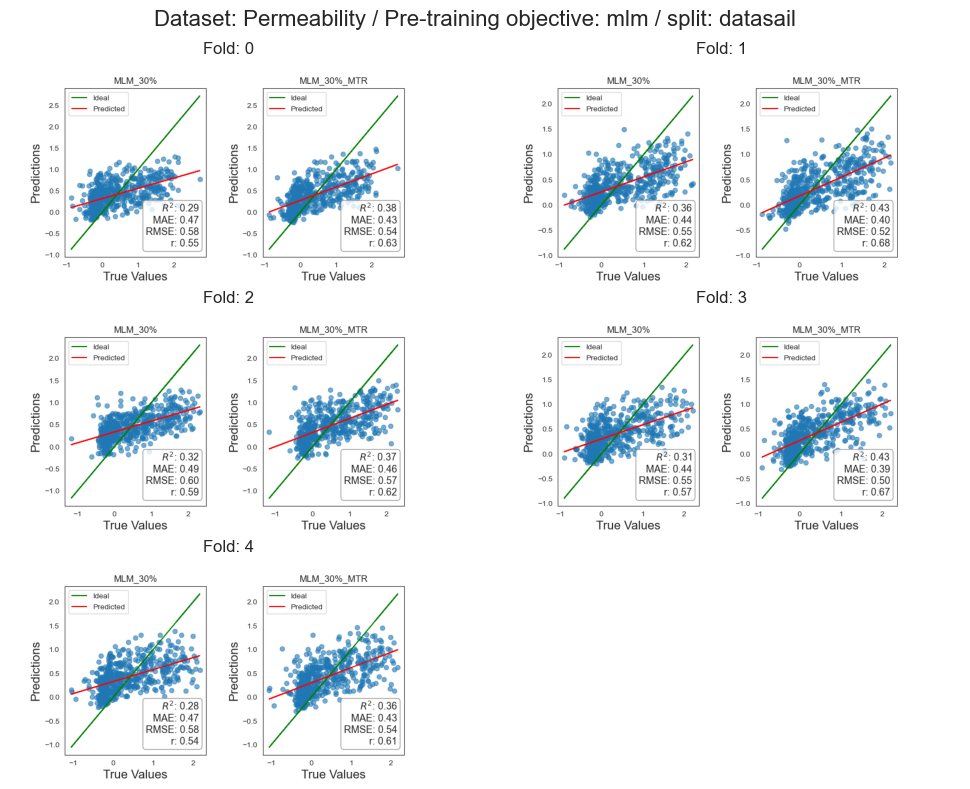

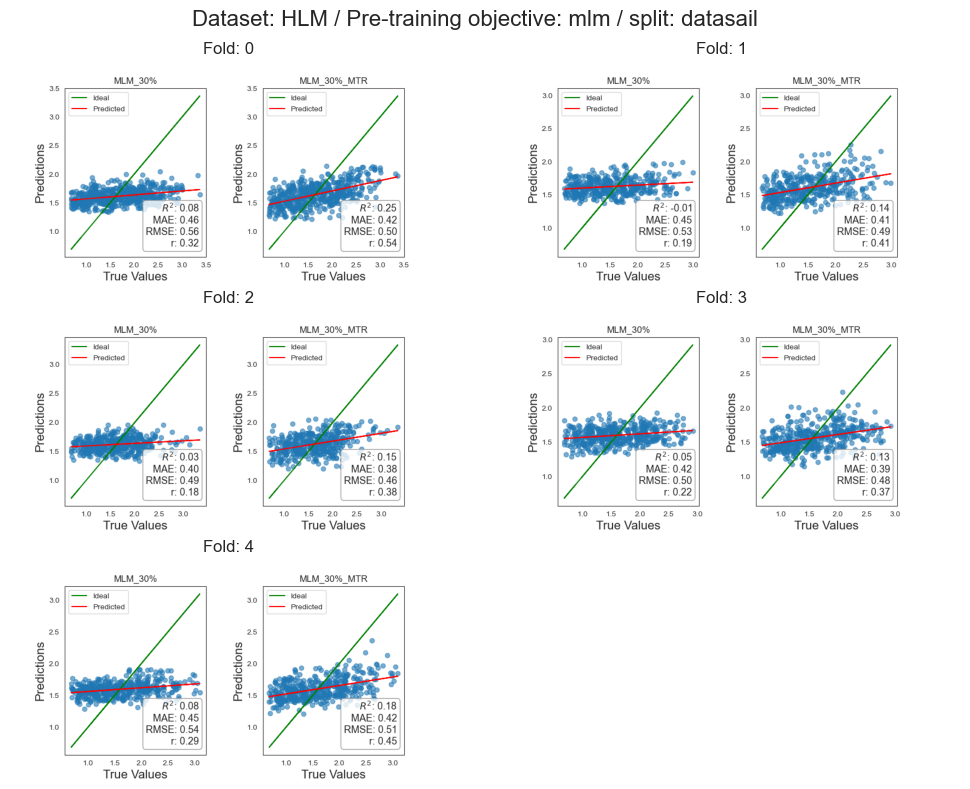

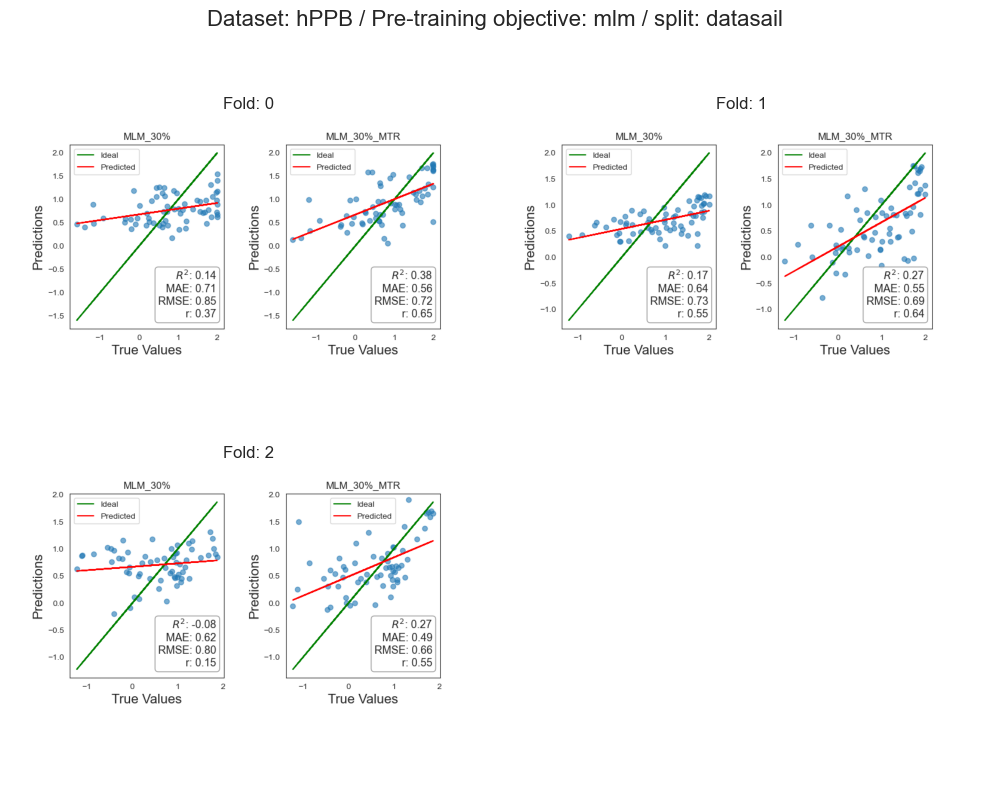

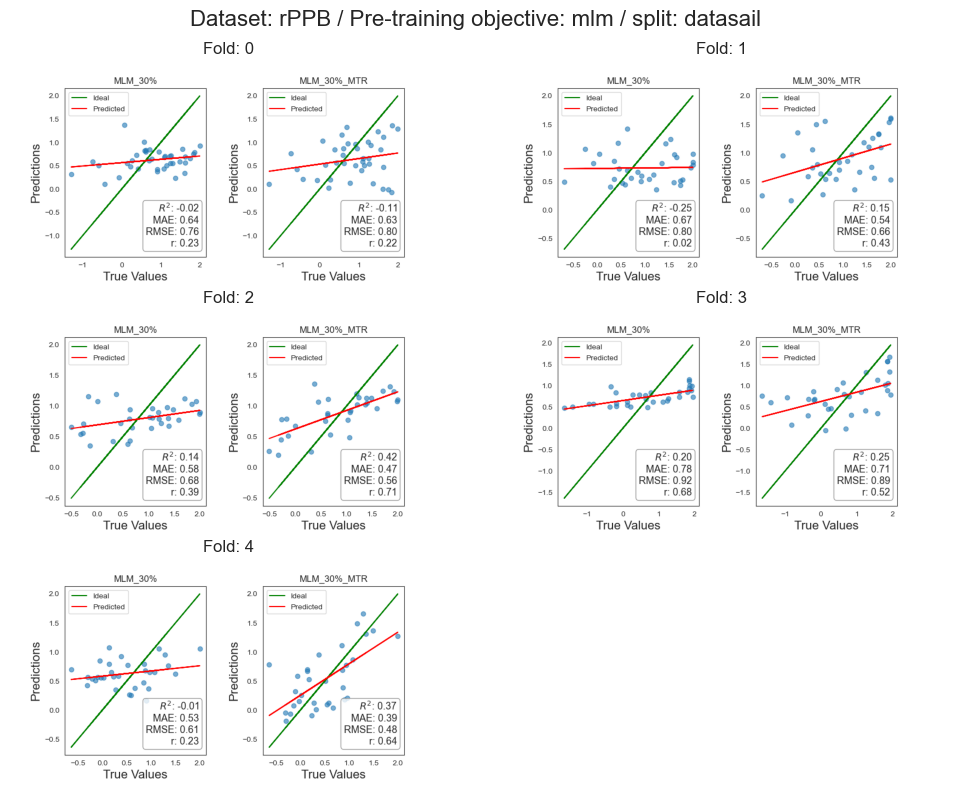

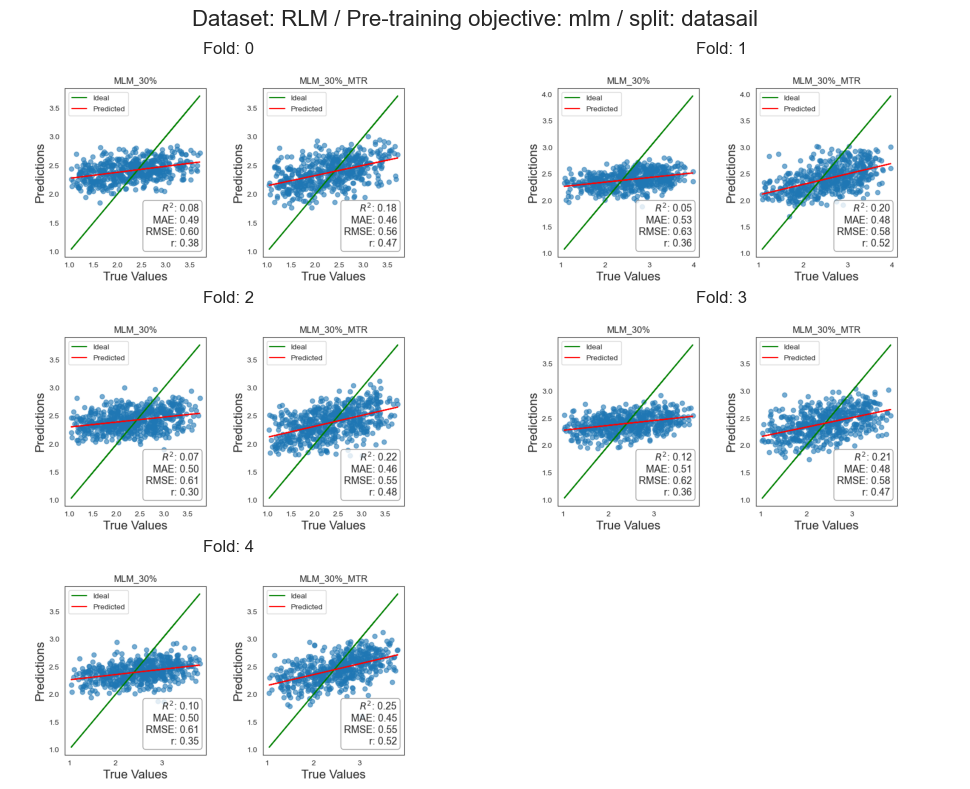

In [11]:
def calculate_metrics(true_vals, preds):
    mae = mean_absolute_error(true_vals, preds)
    rmse = np.sqrt(mean_squared_error(true_vals, preds))
    r2 = r2_score(true_vals, preds)
    pearson_r = r_regression(true_vals.values.reshape(-1, 1), preds.values)
    return mae, rmse, r2, pearson_r[0]

plt.close()

pretrain_objective = 'mlm'
objective_df = raw_df_by_objective[pretrain_objective]

comparison_da_models = ['No DA', 'MTR']
train_size = 30

for idx, ds in enumerate(datasets):
    ds_df = objective_df[(objective_df['dataset'] == ds) & (objective_df['train_size'] == train_size)]
    folds = ds_df['split'].unique().tolist()
    fig, outer_axs = plt.subplots(3 if len(folds) == 5 else 2, 2, figsize=(10, 8))
    outer_axs = outer_axs.flatten()  # Flatten into a 1D array
    
    for i, fold in enumerate(folds):
        inner_fig, inner_axs = plt.subplots(1, 2, figsize=(8, 4))
        inner_axs = inner_axs.flatten()  # Flatten into a 1D array

        fold_df = ds_df[ds_df['split'] == i]
        
        for ax_idx, model in enumerate(comparison_da_models):
            model_df = fold_df[fold_df['da'] == model]
            true_values = model_df['true values']
            predictions = model_df['predictions']
            mae, rmse, r2, pearson_r = calculate_metrics(true_values, predictions)
            
            # Plot true vs. predicted values
            ax = inner_axs[ax_idx]
            ax.scatter(true_values, predictions, alpha=0.6, label='')
            
            # Plot ideal and predicted fitted lines
            ax.plot(true_values, true_values, color='green', linestyle='-' , label='Ideal')
            a, b = np.polyfit(true_values, predictions, 1)
            ax.plot(true_values, a * true_values + b, color='red', linestyle='-' , label='Predicted')

        
            # Display evaluation metrics
            metrics_text = f"$R^2$: {r2:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nr: {pearson_r:.2f}"
            props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
            ax.text(0.95, 0.05, metrics_text, transform=ax.transAxes, fontsize=fontsize-5,
                    verticalalignment='bottom', horizontalalignment='right', bbox=props)
            ax.set_xlabel('True Values', fontsize=fontsize-2)
            ax.set_ylabel('Predictions', fontsize=fontsize-2)
            ax.set_ylim(ax.get_xlim())
            ax_title = f'{pretrain_objective.upper()}_{train_size}%'
            if model != 'No DA':
                ax_title += f'_{model}'
            ax.set_title(ax_title)
            
            ax.legend()
    
        inner_fig.subplots_adjust(hspace=0.3, wspace=0.4)
    
        # Render the inner figure as an image with high DPI
        canvas = FigureCanvas(inner_fig)
        canvas.draw()
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(inner_fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(inner_fig)  # Close the inner figure to prevent overlap
        # Place the image into the outer grid
        outer_axs[i].imshow(image)
        outer_axs[i].set_title(f"Fold: {fold}")
        outer_axs[i].axis('off')
    outer_axs[-1].axis('off')

    fig.suptitle(f"Dataset: {ds} / Pre-training objective: {pretrain_objective} / split: {split_file}", fontsize=16)
    plt.savefig(os.path.join(out_dir, f'{pretrain_objective}_{ds}_raw_predictions.{figure_extension}'))
    plt.tight_layout()

## Comparing domain adaptation across pre-training dataset size
The previous analysis showed that the domain adaptation using the MTR objectives is significantly improving performance for each pre-training setup. The below code compares each domain-adopted models across the different pre-training dataset size setups.
* This comparison shows to which extent increasing pre-training dataset size is needed when domain adaptation is applied (e.g., increasing pre-training dataset size can be useful when no domain adaptation is performed, but limited when domain adaptation is applied).
* By identifying the best pre-training-dataset-size to domain-adaptation performance, we are getting closer to achieving the same performance with less computation. Hence, the most efficient setup.  

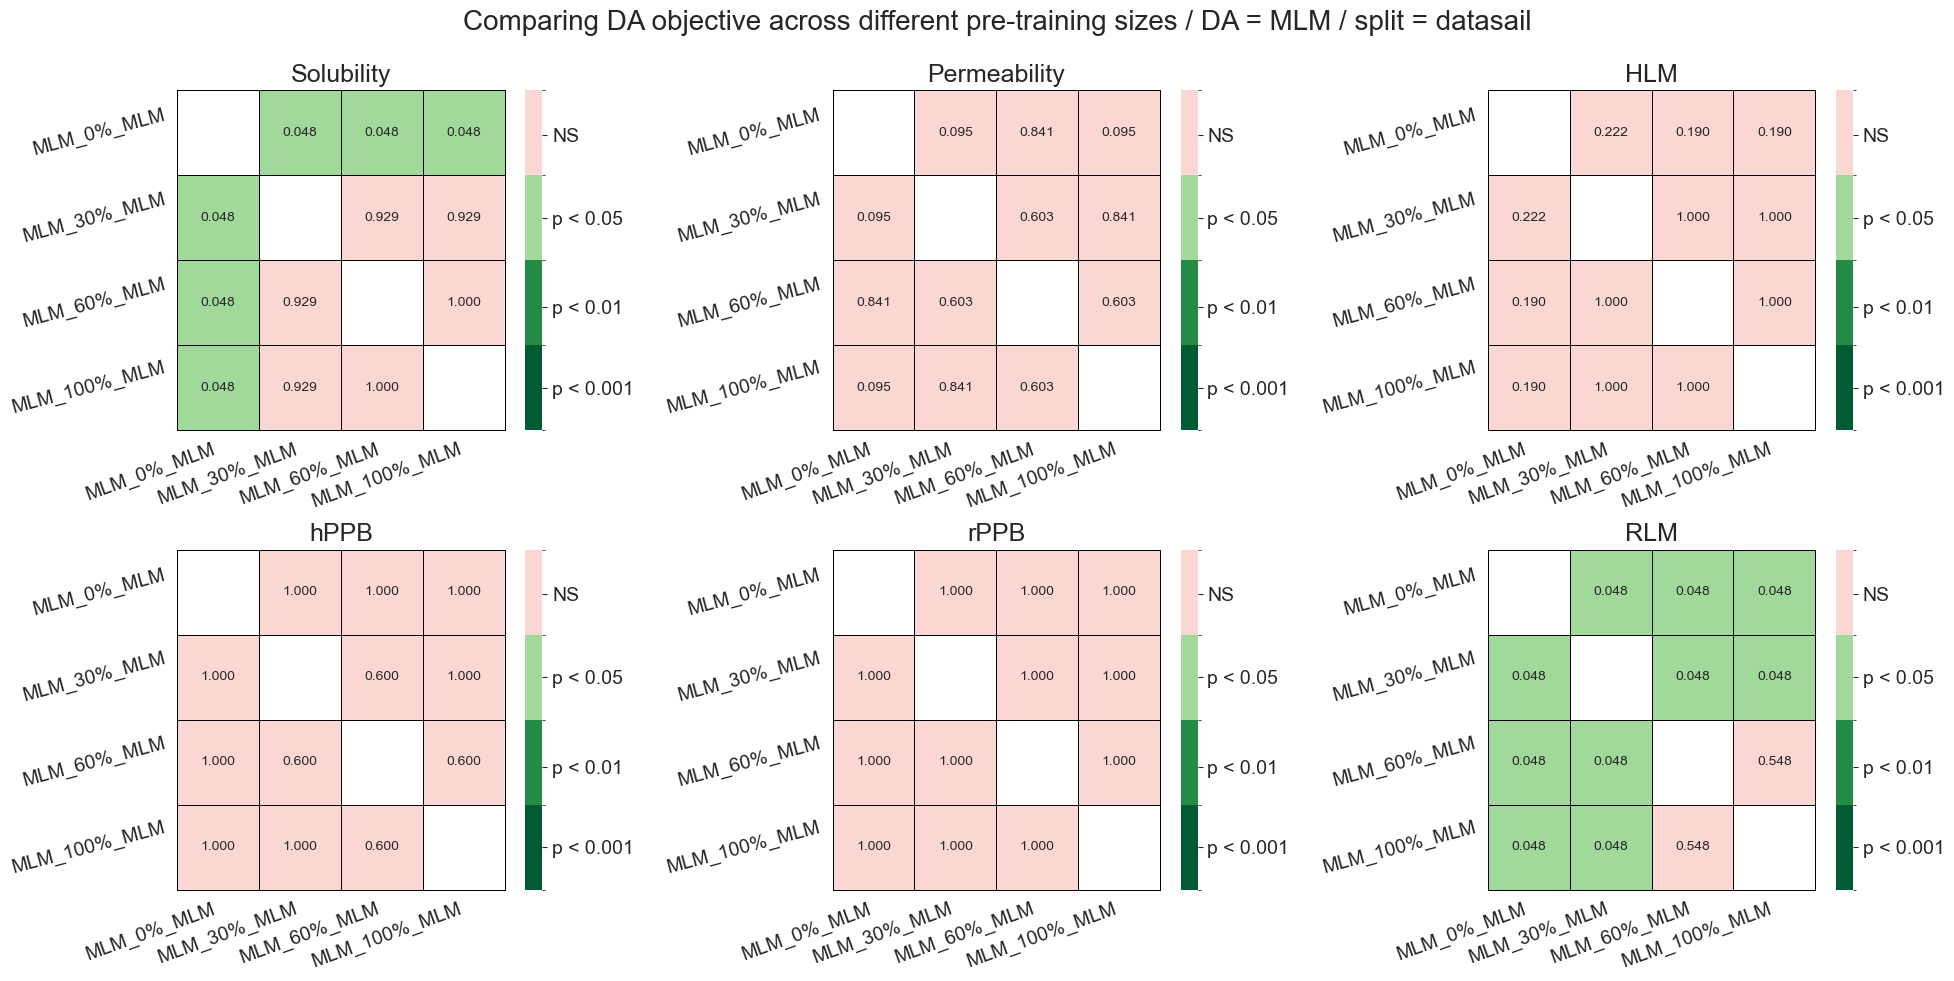

In [12]:
plt.close()
fig_name = "cross_comparison_significance"

for da_model in da_models:
    updated_fig_name = f'{da_model}_da_{fig_name}'
    da_df = mlm_pretrained_models[mlm_pretrained_models['da'] == da_model]
    da_df.loc[:, 'da'] = 'MLM_' + da_df['train_size'].astype(str) + '%' + '_' + da_df['da'].astype(str) 
    
    ncols = 3
    fig_width = 20
    fig_height_ratio = 5
    
    # Create a subplot grid with one subplot for each dataset
    fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
        
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        ax.set_title(dataset, fontsize=fontsize)
        
        df_dataset = da_df[da_df['dataset'] == dataset]
        
        # Perform pairwise comparisons across 'train_size' for the 'None' DA model
        significance_matrix = sp.posthoc_mannwhitney(df_dataset, 
                                                     val_col="value", 
                                                     group_col='da', 
                                                     p_adjust='holm')
        
        x = significance_matrix.copy()
        def extract_percentage(label):
            return int(label.split('_')[1].strip('%'))
        sorted_index = sorted(x.index, key=extract_percentage)
        sorted_columns = sorted(x.columns, key=extract_percentage)
        significance_matrix = x.loc[sorted_index, sorted_columns]
        
        plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
        ax.tick_params(axis='both', labelsize=fontsize-4)
        
        current_labels = [item.get_text() for item in ax.get_xticklabels()]
        ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
        current_labels = [item.get_text() for item in ax.get_yticklabels()]
        ax.set_yticklabels(current_labels, rotation=15, ha='right')
        
    wspace = 0.6 
    hspace = 0.35 
    top = 0.9 
    bottom = 0.1
    right = 0.95
    left = 0.09
    plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
    plt.suptitle(f'Comparing DA objective across different pre-training sizes / DA = {da_model} / split = {split_file}', fontsize=fontsize+2)
    
    plt.savefig(os.path.join(out_dir, f'{updated_fig_name}.{figure_extension}'))
    
    plt.show()

## How to efficiently use the MTR objective
We already showed that the MTR objective is better than the MLM objective when used during pre-training. We also showed that it improves the performance significantly when used for domain adaptation. So, the question arising is "**should we use MTR for pre-training, domain adaptation, and/or both?**"
* MTR is an expensive objective to calculate for millions of molecules and to optimize by the model. So, using it during pre-training comes with a cost. Is the cost worth it?

The below analysis tries to answer this question by comparing 4 models that span no use of MTR at all to using MTR during both pre-training and domain adaptation (the 30% pre-training dataset size setup is fixed for all models):
1. pre-training with MLM and no domain adaptation `MLM_30%_No DA`
2. pre-training with MLM and domain adaptation with MTR `MLM_30%_MTR`
3. pre-training with MTR and no domain adaptation `MTR_30%_No DA`
4. pre-training with MTR and domain adaptation with MTR `MTR_30%_MTR`

The most efficient model that uses MTR is the `MLM_30%_MTR` because the model is pre-trained with the very simple MLM objective, and MTR is used for domain adaptation only, which is performed for a few thousand molecules. 


In [13]:
mtr_30_none = mtr_pretrained_models[(mtr_pretrained_models['objective'] == 'mtr') & (mtr_pretrained_models['da'] == 'No DA') & (mtr_pretrained_models['train_size'] == 30)]
mtr_30_none.loc[:, 'da'] = 'MTR_30%_No DA'
mtr_30_mtr = mtr_pretrained_models[(mtr_pretrained_models['objective'] == 'mtr') & (mtr_pretrained_models['da'] == 'MTR') & (mtr_pretrained_models['train_size'] == 30)]
mtr_30_mtr.loc[:, 'da'] = 'MTR_30%_MTR'

mlm_30_none = mlm_pretrained_models[(mlm_pretrained_models['objective'] == 'mlm') & (mlm_pretrained_models['da'] == 'No DA') & (mlm_pretrained_models['train_size'] == 30)]
mlm_30_none.loc[:, 'da'] = 'MLM_30%_No DA'
mlm_30_mtr = mlm_pretrained_models[(mlm_pretrained_models['objective'] == 'mlm') & (mlm_pretrained_models['da'] == 'MTR') & (mlm_pretrained_models['train_size'] == 30)]
mlm_30_mtr.loc[:, 'da'] = 'MLM_30%_MTR'

mlm_vs_mtr_vs_da_30 = pd.concat([mlm_30_none, mlm_30_mtr, mtr_30_none, mtr_30_mtr]).drop_duplicates()
sort_order = ['MLM_30%_No DA', 'MLM_30%_MTR', 'MTR_30%_No DA', 'MTR_30%_MTR']
mlm_vs_mtr_vs_da_30['da'] = pd.Categorical(mlm_vs_mtr_vs_da_30['da'], categories=sort_order, ordered=True)
mlm_vs_mtr_vs_da_30 = mlm_vs_mtr_vs_da_30.sort_values(by='da')

# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
    ax.set_ylabel(f'{metric_styling[metric]}', fontsize=fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    
    ds_df = mlm_vs_mtr_vs_da_30[mlm_vs_mtr_vs_da_30['dataset'] == ds]
    
    sns.boxplot(data=ds_df, x='da', y='value', color='gray', width=0.3, showmeans=True, fill=False, ax=ax)
    
    # Overlay individual data points
    sns.stripplot(data=ds_df, x='da', y='value', color='skyblue', jitter=0.3, size=5, zorder=1, ax=ax)
        
    ax.set_xlabel('', fontsize=fontsize)
    for label in ax.get_xticklabels():
        label.set_rotation(30)  
        label.set_ha('right')

plt.subplots_adjust(hspace=0.6, wspace=0.3)

plt.suptitle(f'Comparing the MTR objective during pre-training and/vs domain adaptation / split = {split_file}', fontsize=fontsize)

plt.savefig(os.path.join(out_dir,f'mtr_pretrain_vs_da.{figure_extension}'), bbox_inches='tight')

### Significance analysis
The below code shows the significance analysis for the above 4 models. 

In [14]:
plt.close()
fig_name = "mtr_pretrain_vs_da_significance"

ncols = 3
fig_width = 20
fig_height_ratio = 5
    
# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(dataset, fontsize=fontsize)
        
    df_dataset = mlm_vs_mtr_vs_da_30[mlm_vs_mtr_vs_da_30['dataset'] == dataset]
        
    # Perform pairwise comparisons across 'train_size' for the 'None' DA model
    significance_matrix = sp.posthoc_mannwhitney(df_dataset, 
                                                 val_col="value", 
                                                 group_col='da', 
                                                 p_adjust='holm')
        
    plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
    ax.tick_params(axis='both', labelsize=fontsize-4)
        
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
    current_labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(current_labels, rotation=15, ha='right')
        
wspace = 0.6 
hspace = 0.35 
top = 0.9 
bottom = 0.1
right = 0.95
left = 0.08
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
plt.suptitle(f'Significance analysis of the MTR objective during pre-training and/vs domain adaptation / split = {split_file}', fontsize=fontsize+2)
    
plt.savefig(os.path.join(out_dir, f'{fig_name}.{figure_extension}'))
    
plt.show()

/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:1954: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xg = x.groupby(_group_col)[_val_col]
/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:1954: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xg = x.groupby(_group_col)[_val_col]
/Users/afnan_sultan/miniconda3/envs/emtrl_datasail/lib/python3.10/site-packages/scikit_posthocs/_posthocs.py:1954: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

# Comparison to literature

## Loading comparison results
Here, we load the same files as loaded for our experiments, the raw predictions by the models and the evaluated predictions. The models are:
1. MolBERT
2. MolFormer
3. RF + PhysChem properties
4. RF + ECFP4 (Morgan fingerprints)

In [15]:
# Loading raw predictions and filtering by algorithm
comparison_raw_values = f'{comparison_dir}/{split_file}_results_all.csv'
comparisons_raw_df = pd.read_csv(comparison_raw_values, index_col=0)
comparisons_raw_df = comparisons_raw_df[comparisons_raw_df["algorithm"] == algorithm]

# Loading evaluated predictions and filtering by metric and algorithm
comparison_metrics = f'{comparison_dir}/{split_file}_metrics_df.csv'
comparisons_metrics_df = pd.read_csv(comparison_metrics, index_col=0)
comparisons_metrics_df = comparisons_metrics_df[(comparisons_metrics_df['metric'] == metric) & (comparisons_metrics_df["algorithm"] == algorithm)]    

comparisons_metrics_df['model'] = comparisons_metrics_df['model'].str.replace('PhysChem','RF + PhysChem', regex=False)
comparisons_metrics_df['model'] = comparisons_metrics_df['model'].str.replace('ECFP4','RF + ECFP4', regex=False)

comparison_models_agg = agg_mean_and_sem(df=comparisons_metrics_df, comparison=True)

### Some needed cherry-picking
Here, we show the performance of models from the literature to the most efficient model of our experiments (i.e., `MLM_30%_MTR`: the model pre-trained with the MLM objective, on 30% of the GuacaMol dataset, and domain adopted using the MTR objective on the few hundred/thousand of each endpoint dataset)

* We have 4 literature models, two transformer models and two standard molecular representation models. With more models to compare, the stricter the P-value needs to be, the less signal we can detect. 
    * Comparing the four different models alongside our model ends up losing all the significance signals. 
    * We chose to use one of the standard molecular representation models (namely, `RF + Physchem`) as this model is significantly better than the other model (`RF + ECFP`) (see the figures below). Also, the `RF + PhysChem` is more suitable for comparison as it used the same PhysChem properties that were used to domain-adopt our model. 

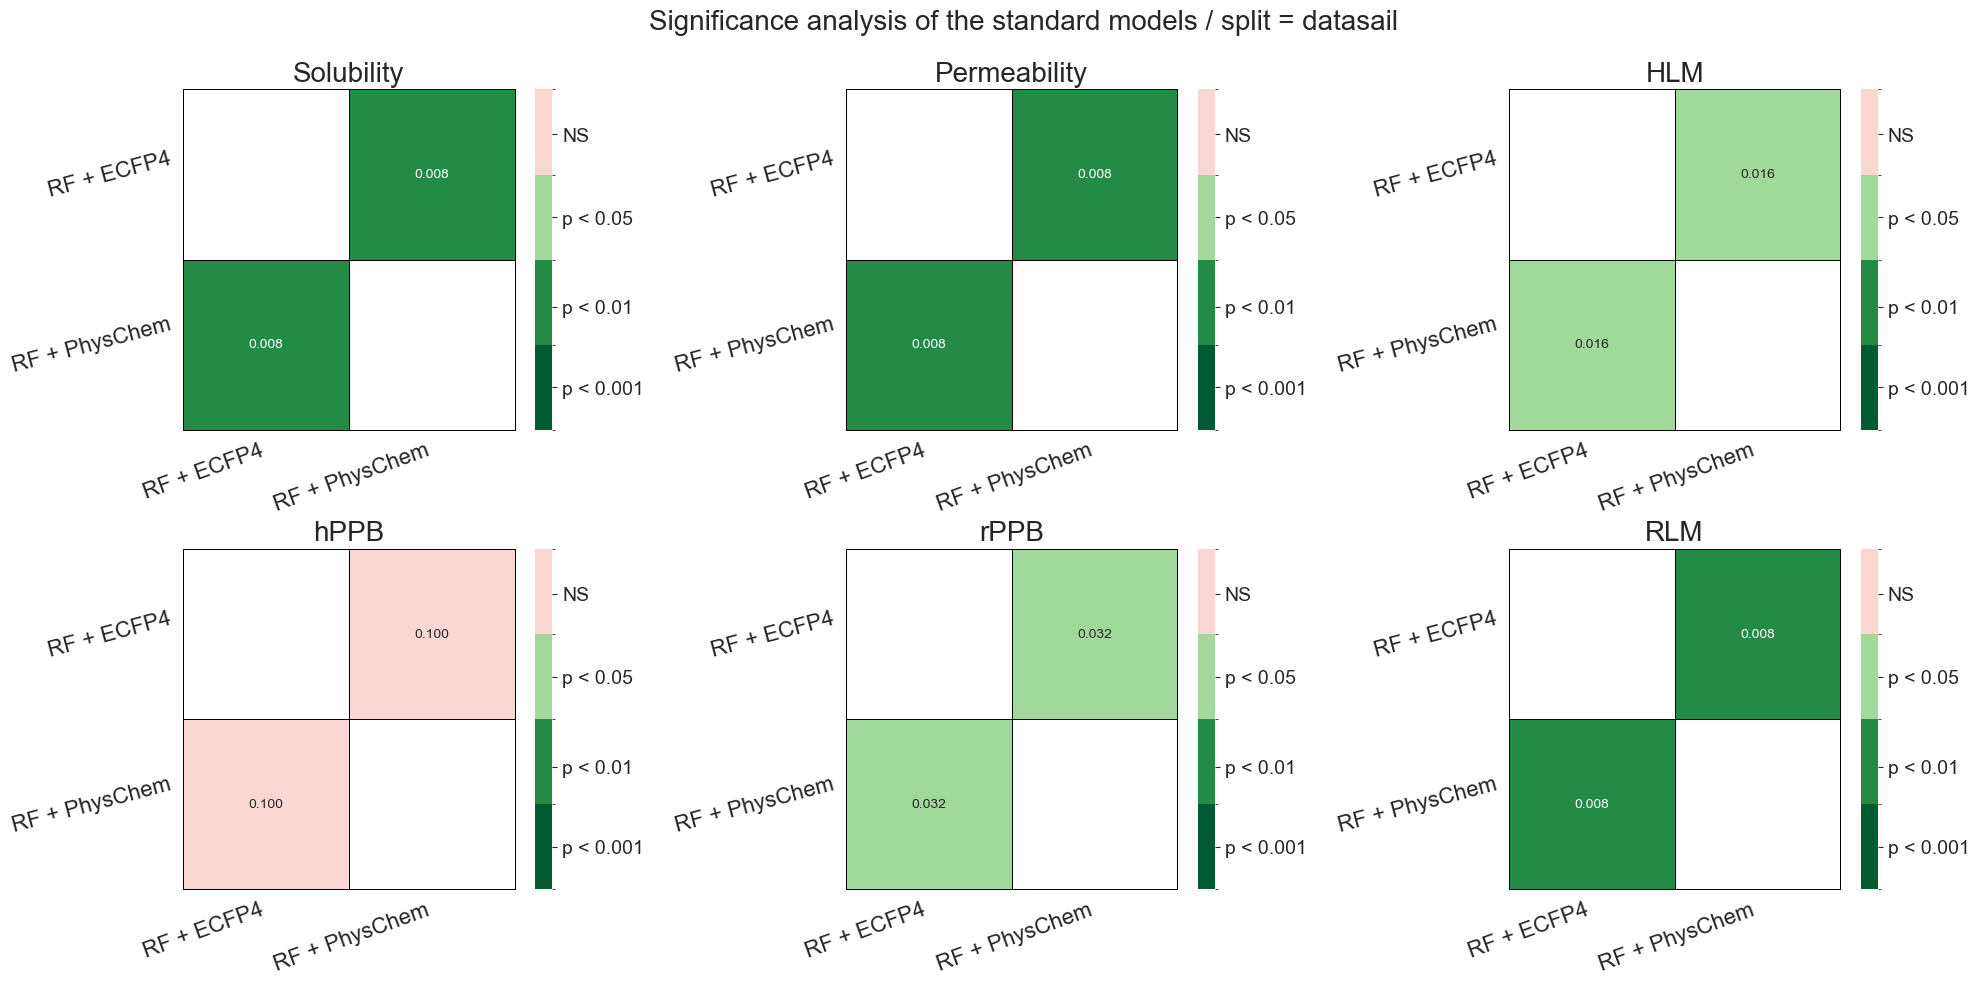

In [16]:
standard_models = comparisons_metrics_df[comparisons_metrics_df['model'].isin(['RF + PhysChem', 'RF + ECFP4'])]

fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
    ax.set_ylabel(f'{metric_styling[metric]}', fontsize=fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    
    ds_df = standard_models[standard_models['dataset'] == ds].sort_values(by='model')
    
    sns.boxplot(data=ds_df, x='model', y='value', color='gray', width=0.3, showmeans=True, fill=False, ax=ax)
    
    # Overlay individual data points
    sns.stripplot(data=ds_df, x='model', y='value', color='skyblue', jitter=0.3, size=5, zorder=1, ax=ax)
        
    ax.set_xlabel('', fontsize=fontsize)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.subplots_adjust(hspace=0.6, wspace=0.3)

plt.suptitle(f'Comparison of the standard models / split = {split_file}', fontsize=fontsize)
plt.savefig(os.path.join(out_dir, f'standard_models_comparison_boxplot.{figure_extension}'))
plt.show()

plt.close()
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(dataset, fontsize=fontsize+2)
        
    df_dataset = standard_models[standard_models['dataset'] == dataset]
        
    # Perform pairwise comparisons across 'train_size' for the 'None' DA model
    significance_matrix = sp.posthoc_mannwhitney(df_dataset, 
                                                 val_col="value", 
                                                 group_col='model', 
                                                 p_adjust='holm')
        
    plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
    ax.tick_params(axis='both', labelsize=fontsize-2)
        
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
    current_labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(current_labels, rotation=15, ha='right')
        
wspace = 0.6 
hspace = 0.35 
top = 0.9 
bottom = 0.1
right = 0.95
left = 0.08
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
plt.suptitle(f'Significance analysis of the standard models / split = {split_file}', fontsize=fontsize+2)
plt.savefig(os.path.join(out_dir, f'standard_models_comparison_significance.{figure_extension}'))
plt.show()
    

## Comparing our most efficient model to literature
Our model is extremely efficient compared to the other two transformer models
* Ours vs MolBERT: 
    * pre-training molecules: 400K vs 1.3M
    * Pre-training objectives: MLM vs MLM + MTR + SMILES-EQ
* Ours vs MolFormer:
    * pre-training molecules: 400K vs 100M
    * Pre-training objectives: MLM vs MLM

/var/folders/73/c3m40qq90r7g0_s26wvg817m0000gn/T/ipykernel_33762/1636672353.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrain_da.loc[:, 'model'] = pretrain_objective.upper() + '_' + pretrain_da['train_size'].astype(str) + '%' + '_' + pretrain_da['da'].astype(str)


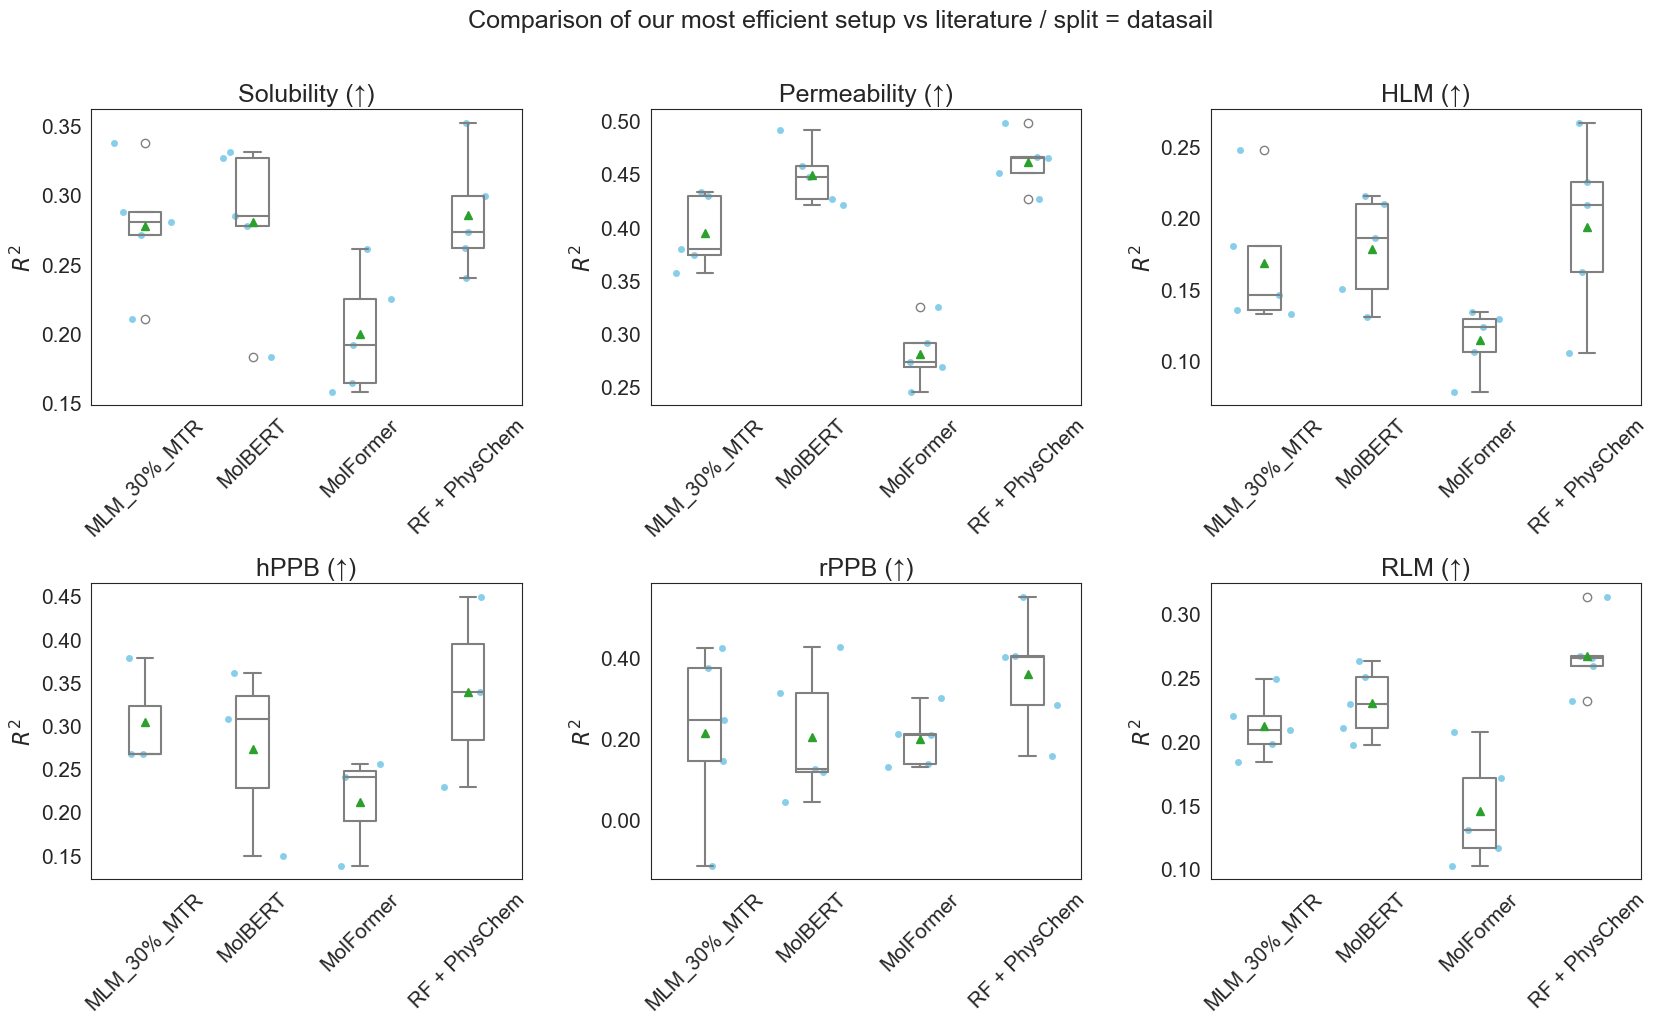

In [17]:
plt.close()

pretrain_objective = 'mlm'
pretrain_objective_df = df_by_objective[pretrain_objective]
comp_size = 30
best_da = 'MTR'
pretrain_da = pretrain_objective_df[(pretrain_objective_df['da'] == best_da) & (pretrain_objective_df['train_size'] == comp_size)]
pretrain_da.loc[:, 'model'] = pretrain_objective.upper() + '_' + pretrain_da['train_size'].astype(str) + '%' + '_' + pretrain_da['da'].astype(str) 
literature_plus_ours = pd.concat([comparisons_metrics_df, pretrain_da]).drop_duplicates()

# removing the ECFP4 model to be able to detect signals. The more models, the stricter the P-value, the fewer signals captured. You can also remove the PhysChem model and compare the ECFP4 model by switching the commenting of the below two lines, or compare all models by commenting the two lines.
literature_plus_ours = literature_plus_ours[literature_plus_ours['model'] != 'RF + ECFP4']
# literature_plus_ours = literature_plus_ours[literature_plus_ours['model'] != 'RF + PhysChem']

# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, ds in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(f'{ds} ({arrow_direction[metric]})', fontsize=fontsize)
    ax.set_ylabel(f'{metric_styling[metric]}', fontsize=fontsize-2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-3)
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    
    ds_df = literature_plus_ours[literature_plus_ours['dataset'] == ds].sort_values(by='model')
    
    sns.boxplot(data=ds_df, x='model', y='value', color='gray', width=0.3, showmeans=True, fill=False, ax=ax)
    
    # Overlay individual data points
    sns.stripplot(data=ds_df, x='model', y='value', color='skyblue', jitter=0.3, size=5, zorder=1, ax=ax)
        
    ax.set_xlabel('', fontsize=fontsize)
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.subplots_adjust(hspace=0.6, wspace=0.3)

plt.suptitle(f'Comparison of our most efficient setup vs literature / split = {split_file}', fontsize=fontsize)
plt.savefig(os.path.join(out_dir,f'{pretrain_objective}_{comp_size}_{best_da}_vs_literature_boxplot.{figure_extension}'), bbox_inches='tight')

### Significance analysis

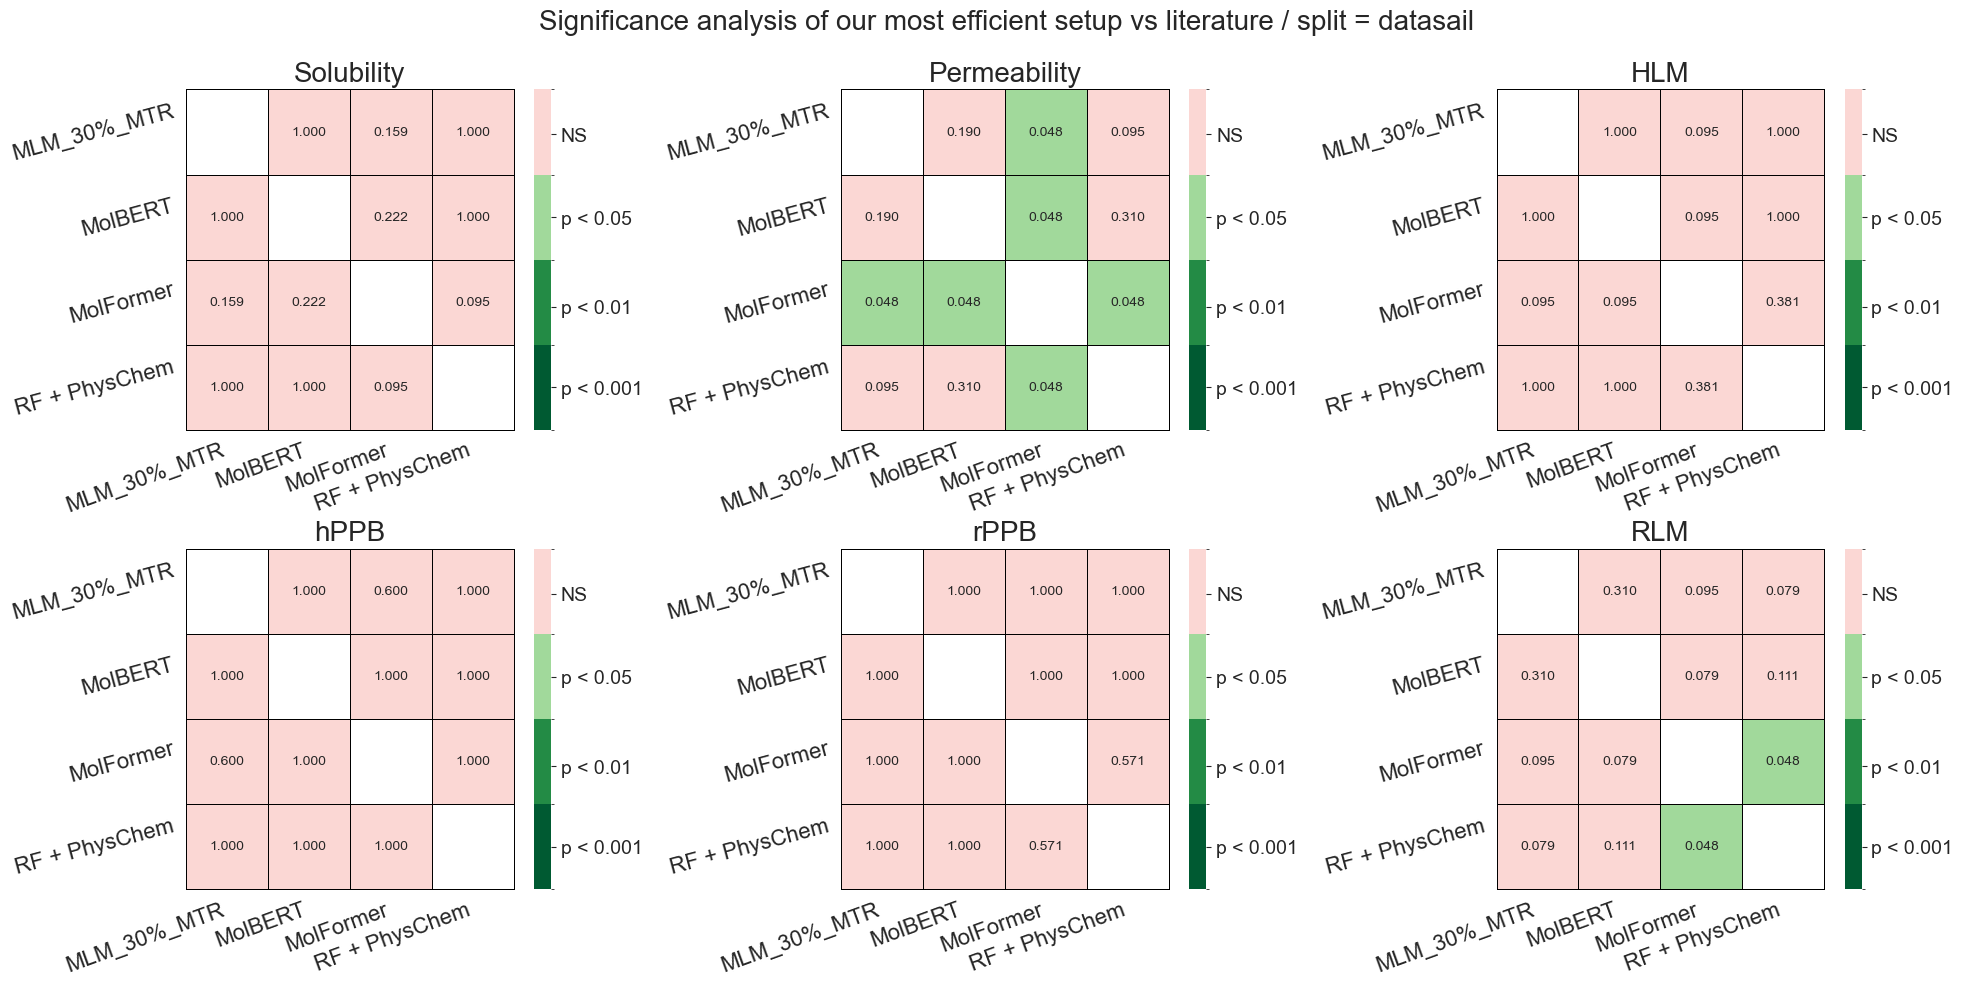

In [18]:
plt.close()
fig_width = 20
fig_height_ratio = 5
    
# Create a subplot grid with one subplot for each dataset
fig, axes = make_figure(len(datasets), ncols, width=fig_width, height_ratio=fig_height_ratio)
for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    ax.set_title(dataset, fontsize=fontsize+2)
        
    df_dataset = literature_plus_ours[literature_plus_ours['dataset'] == dataset]
        
    # Perform pairwise comparisons across 'train_size' for the 'None' DA model
    significance_matrix = sp.posthoc_mannwhitney(df_dataset, 
                                                 val_col="value", 
                                                 group_col='model', 
                                                 p_adjust='holm')
        
    plot_sns_heatmap(significance_matrix, ax, apply_mask=True)
    ax.tick_params(axis='both', labelsize=fontsize-2)
        
    current_labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(current_labels, rotation=20, ha='right')
            
    current_labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels(current_labels, rotation=15, ha='right')
        
wspace = 0.6 
hspace = 0.35 
top = 0.9 
bottom = 0.1
right = 0.95
left = 0.09
plt.subplots_adjust(top=top, bottom=bottom, right=right, left=left, wspace=wspace, hspace=hspace)  
    
plt.suptitle(f'Significance analysis of our most efficient setup vs literature / split = {split_file}', fontsize=fontsize+2)
    
plt.savefig(os.path.join(out_dir,f'{pretrain_objective}_{comp_size}_{best_da}_vs_literature_significance.{figure_extension}'), bbox_inches='tight')
    
plt.show()